In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cpi

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    make_scorer,
    mean_squared_log_error,
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

In [262]:
actors = pd.read_csv("train_actor.csv")
print(actors.columns)

Index(['imdb_id', 'actor_id', 'actor_name', 'gender', 'popularity'], dtype='object')


In [263]:
data = pd.read_csv("train.csv")
data.index = data["imdb_id"]
data = data[
    [
        "release_date",
        "runtime",
        "genres",
        "budget",
        "popularity",
        "production_companies",
        "revenue",
    ]
]
# data = data[data["runtime"] >= 10]
# data = data[data["budget"] != 0]
data = data[data["revenue"] >= 1000]

In [264]:
actors = actors.sort_values(by="popularity", ascending=False)
# Calculate the cast's gender ratio
actors["gender_ratio"] = actors.groupby("imdb_id")["gender"].transform(
    lambda x: x.mean()
)
# Calculate the cast's popularity
actors["cast_popularity"] = actors.groupby("imdb_id")["popularity"].transform(
    lambda x: x.mean()
)
# Calculate how many award-winning actors are in the cast by seeing if the popularity of the actor is in the top 10% of the dataset
actors["award_winning_actor"] = actors["popularity"] >= actors["popularity"].quantile(
    0.9
)
actors
# Create a new dataframe to count the number of award winning actors
awardee = actors.groupby("imdb_id")["award_winning_actor"].sum()
# Set the index to imdb_id and
awardee

imdb_id
tt0004972    0
tt0006333    0
tt0012349    1
tt0015400    0
tt0015648    0
            ..
tt5946128    1
tt6003368    1
tt6201292    0
tt6574272    0
tt6673840    0
Name: award_winning_actor, Length: 2992, dtype: int64

In [265]:
data["award_winning_actor"] = awardee

In [266]:
# Extract temporal features from release_date
data["release_date"] = pd.to_datetime(data["release_date"])
# Convert years beyond 2023 to 100 years ago
data["release_date"] = data["release_date"].apply(
    lambda x: x if x.year < 2023 else x.replace(year=x.year - 100)
)
data["week_number"] = data["release_date"].dt.isocalendar().week
# Adjust week number for the movies released in the last week of the year
data["week_number"] = data["week_number"].apply(lambda x: 1 if x == 53 else x)
data["year"] = data["release_date"].dt.year

# Add CPI as a feature
data["cpi"] = data["release_date"].apply(lambda x: cpi.get(x.year))

data = data.drop(columns=["release_date"])

In [267]:
# Handle missing budget or zero budget by replacing with the median budget of that year
data["budget"] = data["budget"].replace(0, np.nan)
data["budget"] = data["budget"].fillna(
    data.groupby("year")["budget"].transform("median")
)

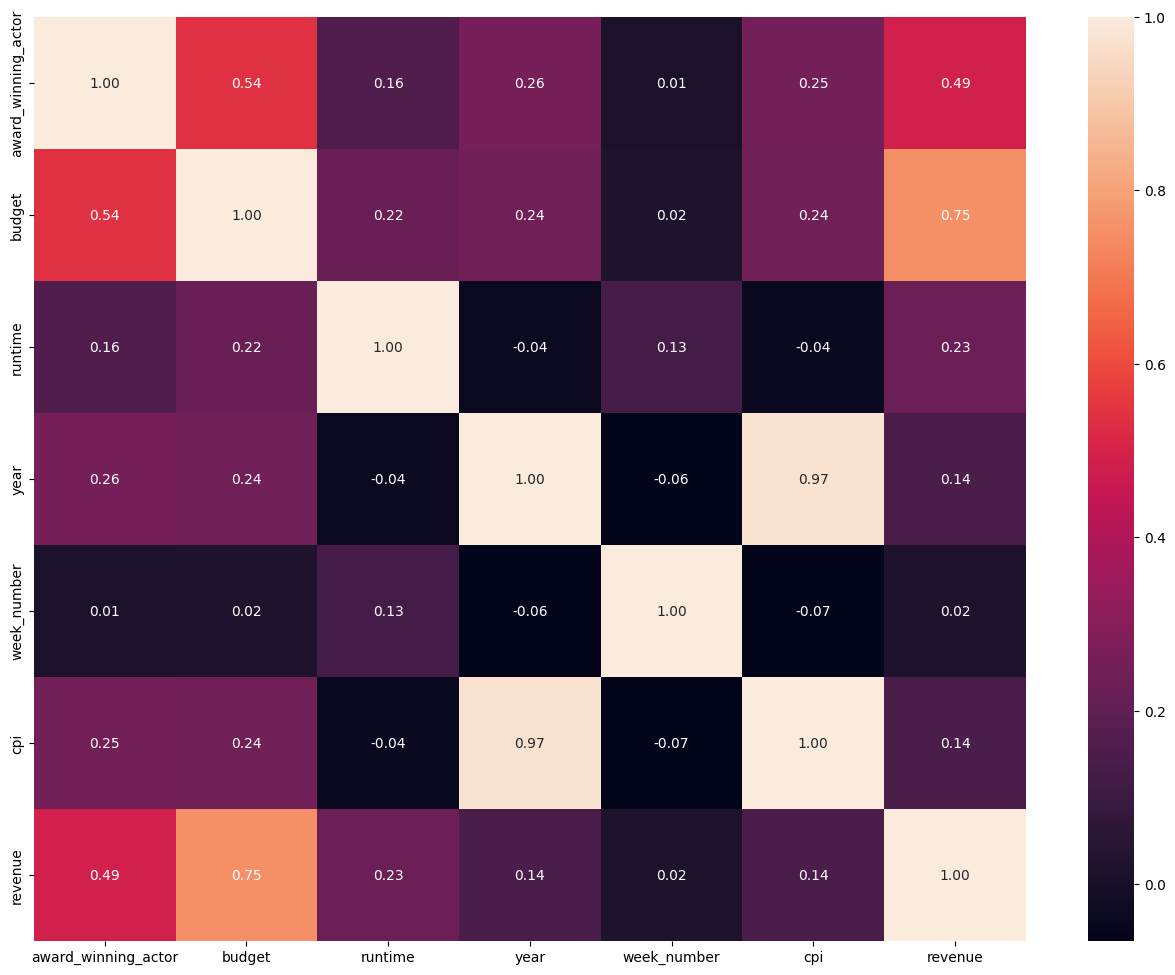

In [268]:
# Plot correlation matrix
corr = data[["award_winning_actor", "budget", "runtime", "year", "week_number", "cpi", "revenue"]].corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

In [269]:
for col in ["genres", "production_companies"]:
    data[col] = data[col].astype(str)
    data[col] = "list(" + data[col] + ")"
    data[col] = data[col].fillna("[]").apply(eval)
    data[col] = data[col].apply(lambda x: [i["id"] for i in x])

In [270]:
data.head()

,runtime,genres,budget,popularity,production_companies,revenue,award_winning_actor,week_number,year,cpi
imdb_id,,,,,,,,,,
tt2637294,93,[35],36000000.0,17.651,"[60, 4, 21]",64780213,6.0,8,2015,237.017
tt0368933,113,"[35, 18, 10751, 10749]",40000000.0,38.600,"[26423, 2]",134734481,7.0,32,2004,188.900
tt2582802,107,"[18, 10402]",3300000.0,112.735,"[2266, 3172, 32157, 24049]",13092000,3.0,41,2014,236.736
tt1821480,122,"[9648, 53]",1200000.0,7.955,"[6808, 103329, 164741]",16000000,0.0,10,2012,229.594
tt1380152,118,"[28, 53]",17250000.0,5.219,"[3655, 7036]",3923970,0.0,6,2009,214.537


In [271]:
# One-hot encode genres
genres = pd.Series(data["genres"].sum()).value_counts()
genres = genres[genres > 10].index.tolist()
for genre in genres:
    data["genre_" + str(genre)] = data["genres"].apply(lambda x: genre in x)
data = data.drop(columns=["genres"])

In [272]:
# One-hot encode production companies
# companies = pd.Series(data["production_companies"].sum()).value_counts()
# companies = companies[companies > 10].index.tolist()
# for company in companies:
#     data["company_" + str(company)] = data["production_companies"].apply(
#         lambda x: company in x
#     )
data = data.drop(columns=["production_companies"])

In [273]:
data.head()

,runtime,budget,popularity,revenue,award_winning_actor,week_number,year,cpi,genre_18,genre_35,...,genre_878,genre_14,genre_10751,genre_9648,genre_36,genre_16,genre_10752,genre_10402,genre_99,genre_37
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt2637294,93,36000000.0,17.651,64780213,6.0,8,2015,237.017,False,True,...,False,False,False,False,False,False,False,False,False,False
tt0368933,113,40000000.0,38.600,134734481,7.0,32,2004,188.900,True,True,...,False,False,True,False,False,False,False,False,False,False
tt2582802,107,3300000.0,112.735,13092000,3.0,41,2014,236.736,True,False,...,False,False,False,False,False,False,False,True,False,False
tt1821480,122,1200000.0,7.955,16000000,0.0,10,2012,229.594,False,False,...,False,False,False,True,False,False,False,False,False,False
tt1380152,118,17250000.0,5.219,3923970,0.0,6,2009,214.537,False,False,...,False,False,False,False,False,False,False,False,False,False


In [274]:
data = data.dropna()
data.to_csv("train_processed.csv")

In [275]:
train, test = train_test_split(data, test_size=0.2, random_state=42)
X_train = train.drop("revenue", axis=1)
y_train = train["revenue"]
X_test = test.drop("revenue", axis=1)
y_test = test["revenue"]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2348, 25) (2348,)
(587, 25) (587,)


In [276]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))


rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [277]:
model = make_pipeline(
    StandardScaler(),
    # PCA(n_components=0.99),
    RandomForestRegressor(),
)
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor())])

In [278]:
print(
    "Train R2:",
    cross_val_score(model, X_train, y_train, cv=5, scoring=rmsle_scorer).mean(),
)
print(
    "Test R2:",
    cross_val_score(model, X_test, y_test, cv=5, scoring=rmsle_scorer).mean(),
)

Train R2: -1.8512671574299506
Test R2: -1.9336407613151632


In [279]:
# Print the 10 most important features
feature_importances = pd.DataFrame(
    model.steps[1][1].feature_importances_,
    index=X_train.columns,
    columns=["importance"],
).sort_values("importance", ascending=False)
print(feature_importances.head(10))

                     importance
budget                 0.483672
popularity             0.302376
runtime                0.045422
week_number            0.042830
award_winning_actor    0.039689
year                   0.014759
cpi                    0.014687
genre_12               0.012875
genre_28               0.005492
genre_10749            0.005254
